# Import libraries

In [1]:
import sys
sys.path.append('../')
%matplotlib inline

In [2]:
from utils.utils import calc_AUC, calc_F1_score
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import utils.hsdmdl2_nml as hsdmdl2_nml
import utils.hsdmdl1_nml as hsdmdl1_nml
import utils.sdmdl_nml as sdmdl_nml
import tsmdl.aw2s_mdl as aw2s_mdl
import tsmdl.fw2s_mdl as fw2s_mdl
import dmdl.hsdmdl2 as hsdmdl2
import dmdl.hsdmdl1 as hsdmdl1
import dmdl.sdmdl as sdmdl
from functools import partial
import pandas as pd
import optuna
import changefinder
import bocpd
import datetime as dt
from multiprocessing import Pool
import multiprocessing as multi

/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Production Condition Dataset

In [3]:
df = pd.read_csv('../data/factory_sensor.csv')

In [4]:
X = np.zeros((8, 26450))
for i in range(8):
    # X[i]=np.array(df.iloc[:,i])
    for j in range(1, 26450):
        X[i, j] = df.iloc[j, i]-df.iloc[j-1, i]
    X[i] -= np.mean(X[i, 0:250])
    X[i] /= np.std(X[i, 0:250])
changepoints = np.where(np.array(df.iloc[:, 8] == 1))[0]
changepoints = [667,  2633,  9662, 13229, 17371, 17831, 20130, 25440]
print("Starting Points of Changes: ", changepoints)

Starting Points of Changes:  [667, 2633, 9662, 13229, 17371, 17831, 20130, 25440]


<Figure size 432x288 with 0 Axes>

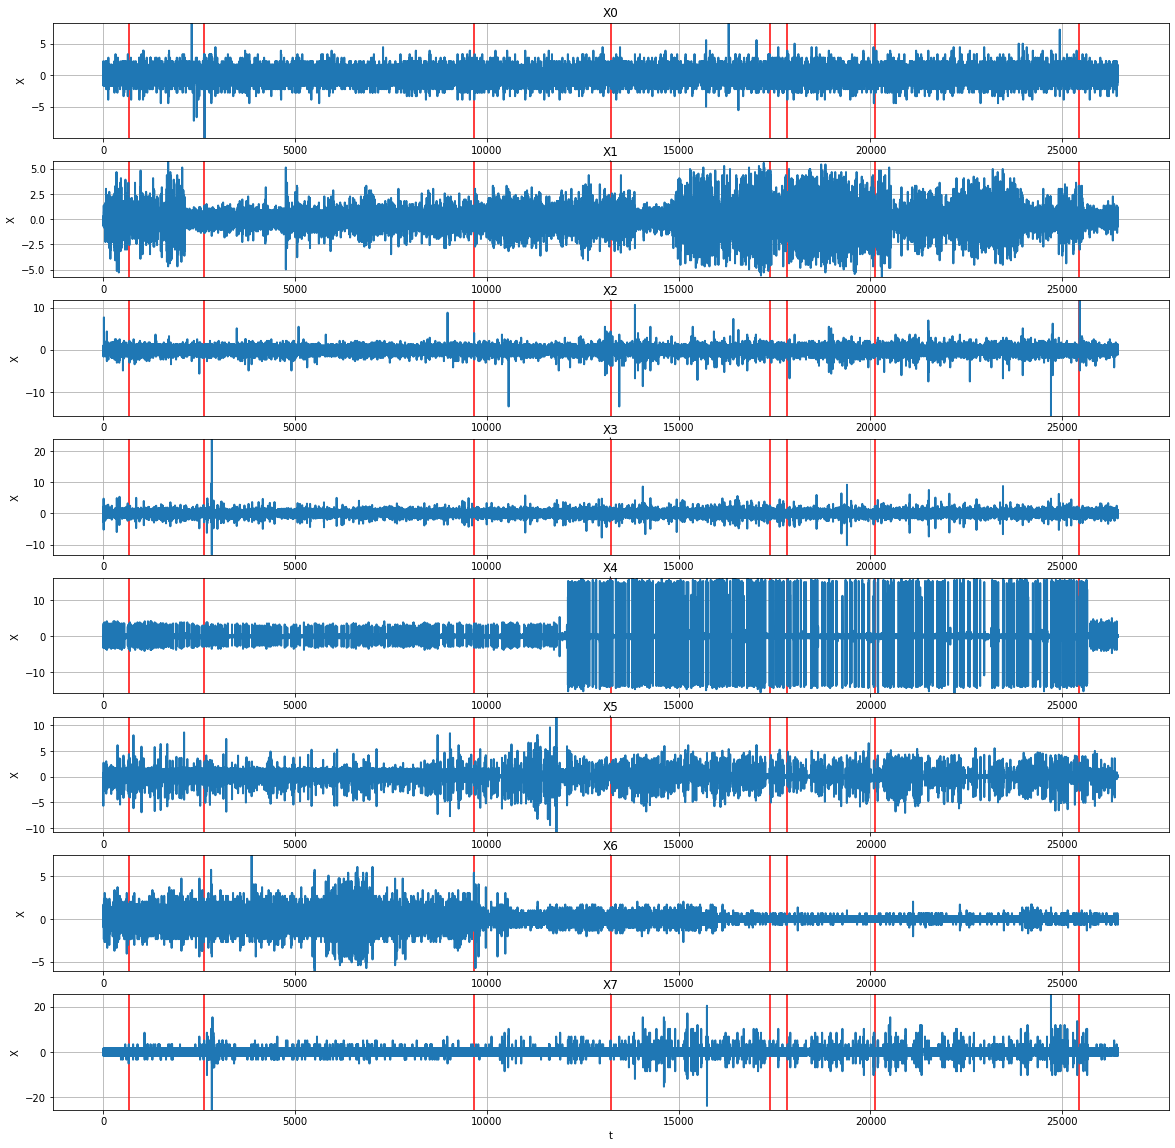

In [5]:
plt.clf()
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(20, 20))

for i in range(8):
    axes[i].plot(X[i], linewidth=2)
    axes[i].set_title('X'+str(i))
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('X')
    axes[i].vlines(changepoints, -100, 100, color="red")
    axes[i].set_ylim(np.min(X[i]), np.max(X[i]))
    axes[i].grid(True)

# Change or change sign detection

In [27]:
# parameters
tolerance_delay =1000
n_trials = 200
both = True
shift=False

In [7]:
# BOCPD
def _objective_BOCPD(trial, train, changepoints, tolerance_delay):
    lam = trial.suggest_int('lam', 100, 1000)
    alpha = trial.suggest_uniform('alpha', 1e-8, 10)
    beta = trial.suggest_uniform('beta', 1e-8, 0.01)
    kappa = trial.suggest_uniform('kappa', 1e-8, 0.01)
    mu = 0
    #mu = trial.suggest_uniform('mu', -1, 1)

    h = partial(bocpd.constant_hazard, lam)
    lik = bocpd.StudentT(alpha, beta, kappa, mu)
    
    retrospective=bocpd.Retrospective(hazard_func=h, likelihood_func=lik)

    scores = np.zeros((8, 26450))
    
    for i in range(8):
        scores[i] = retrospective.calc_scores(train[i])

    scores=np.nanmax(scores, axis=0)
    
    AUC = calc_AUC(scores, changepoints, tolerance_delay, both=both)

    return -AUC


# hyperparameter tuning
#objective_BOCPD = partial(_objective_BOCPD, train=X,
#                          changepoints=changepoints, tolerance_delay=tolerance_delay)
#study = optuna.create_study()
#study.optimize(objective_BOCPD, n_trials=n_trials, n_jobs=-1)

# calculate scores
#opt_lam = study.best_params['lam']
#opt_alpha = study.best_params['alpha']
#opt_beta = study.best_params['beta']
#opt_kappa = study.best_params['kappa']
#opt_mu = study.best_params['mu']
opt_lam = 1000
opt_alpha = 6
opt_beta = 0.1
opt_kappa = 0.1
opt_mu = 0

h = partial(bocpd.constant_hazard, opt_lam)
lik = bocpd.StudentT(opt_alpha, opt_beta, opt_kappa, opt_mu)
retrospective = bocpd.Retrospective(hazard_func=h, likelihood_func=lik)

bocpd_scores = np.zeros((8, 26450))
    
for i in range(8):
    bocpd_scores[i] = retrospective.calc_scores(X[i])

bocpd_scores=np.nanmax(bocpd_scores, axis=0)

In [8]:
# CF
def _objective_CF(trial, train, changepoints, tolerance_delay):
    # hyperparameters
    r = trial.suggest_uniform('r', 0.01, 0.99)
    order = trial.suggest_int('order', 1, 20)
    smooth = trial.suggest_int('smooth', 3, 20)

    retrospective = changefinder.Retrospective(r=r, order=order, smooth=smooth)
    
    scores = np.zeros((8, 26450))
    
    for i in range(8):
        scores[i] = retrospective.calc_scores(train[i])

    scores = np.nanmax(scores, axis=0)    
    
    AUC = calc_AUC(
        scores, changepoints, tolerance_delay, both=both)
    return -AUC


# hyperparameter tuning
#objective_CF = partial(_objective_CF, train=X,
#                       changepoints=changepoints, tolerance_delay=tolerance_delay)
#study = optuna.create_study()
#study.optimize(objective_CF, n_trials=n_trials, n_jobs=-1)
#opt_r = study.best_params['r']
#opt_order = study.best_params['order']
#opt_smooth = study.best_params['smooth']

opt_r = 0.1
opt_order = 10
opt_smooth = 10

retrospective = changefinder.Retrospective(
    r=opt_r, order=opt_order, smooth=opt_smooth)

cf_scores = np.zeros((8, 26450))

for i in range(8):
    cf_scores[i] = retrospective.calc_scores(X[i])

cf_scores = np.nanmax(cf_scores, axis=0)   

/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encountered


In [9]:
# SDMDL 0th
def _objective_SDMDL(trial, train, changepoints, tolerance_delay, params):
    
    nml_multgaussian = partial(sdmdl_nml.nml_multgaussian, R=params["R"], lambda_min=params["lambda_min"])
    complexity_multgaussian = partial(sdmdl_nml.complexity_multgaussian, m=8, R=params["R"], lambda_min=params["lambda_min"])
    
    window_size = trial.suggest_int('window_size', 100, 300)
    retrospective = sdmdl.Retrospective(h=window_size, encoding_func=nml_multgaussian,
                                        complexity_func=complexity_multgaussian, order=params["order"], shift=shift)

    scores = retrospective.calc_scores(train)
    #n = len(scores)
    #scores[2*window_size-1: n] = scores[window_size-1: n-window_size]
    #scores[0:2*window_size] = np.nan

    AUC = calc_AUC(scores, changepoints,  tolerance_delay, both=both)
    return -AUC


R=60
lambda_min=1e-5

params = {"R": R, "lambda_min": lambda_min, "order": 0}

# 0th D-MDL
# hyperparameter tuning
#objective_SDMDL = partial(_objective_SDMDL, train=X.T,
#                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
#study = optuna.create_study()
#study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = 250
#opt_window_size = study.best_params['window_size']

nml_multgaussian = partial(sdmdl_nml.nml_multgaussian, R=params["R"], lambda_min=params["lambda_min"])
complexity_multgaussian = partial(sdmdl_nml.complexity_multgaussian, m=8, R=params["R"], lambda_min=params["lambda_min"])

retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_multgaussian,
                                    complexity_func=complexity_multgaussian, order=params["order"], shift=shift)

sdmdl_0_scores = retrospective.calc_scores(X.T)
#n = len(sdmdl_0_scores)
#sdmdl_0_scores[2*opt_window_size -
#               1: n] = sdmdl_0_scores[opt_window_size-1: n-opt_window_size]
#sdmdl_0_scores[0:2*opt_window_size] = np.nan

# 1st D-MDL
params = {"R": R, "lambda_min": lambda_min, "order": 1}

# hyperparameter tuning
#objective_SDMDL = partial(_objective_SDMDL, train=X.T,
#                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
#study = optuna.create_study()
#study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = 250
#opt_window_size = study.best_params['window_size']

retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_multgaussian,
                                    complexity_func=complexity_multgaussian, order=params["order"], shift=shift)

sdmdl_1_scores = retrospective.calc_scores(X.T)
#n = len(sdmdl_1_scores)
#sdmdl_1_scores[2*opt_window_size -
#               1: n] = sdmdl_1_scores[opt_window_size-1: n-opt_window_size]
#sdmdl_1_scores[0:2*opt_window_size] = np.nan

# 2nd D-MDL
params = {"R": R, "lambda_min": lambda_min, "order": 2}

# hyperparameter tuning
#objective_SDMDL = partial(_objective_SDMDL, train=X.T,
#                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
#study = optuna.create_study()
#study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = 250
#opt_window_size = study.best_params['window_size']

retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_multgaussian,
                                    complexity_func=complexity_multgaussian, order=params["order"], shift=shift)

sdmdl_2_scores = retrospective.calc_scores(X.T)
#n = len(sdmdl_2_scores)
#sdmdl_2_scores[2*opt_window_size -
#               1: n] = sdmdl_2_scores[opt_window_size-1: n-opt_window_size]
#sdmdl_2_scores[0:2*opt_window_size] = np.nan

In [10]:
# FW2S_MDL
def _objective_FW2S_MDL(trial, train, changepoints, tolerance_delay, params):
    nml_multgaussian = partial(sdmdl_nml.nml_multgaussian, R=params["R"], lambda_min=params["lambda_min"])
    complexity_multgaussian = partial(sdmdl_nml.complexity_multgaussian, m=8, R=params["R"], lambda_min=params["lambda_min"])

    nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params[
                           "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params[
                                  "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    delta_0 = trial.suggest_uniform('delta_0', 0.001, 0.499)
    window_size_1 = trial.suggest_int('window_size_1', 100, 300)
    window_size_2 = trial.suggest_int('window_size_2', 100, 300)

    retrospective_first = sdmdl.Retrospective(h=window_size_1, encoding_func=nml_multgaussian,
                                              complexity_func=complexity_multgaussian, delta_0=delta_0, order=0)
    retrospective_second = sdmdl.Retrospective(h=window_size_2, encoding_func=nml_gaussian,
                                               complexity_func=complexity_gaussian, order=0)
    retrospective = fw2s_mdl.Retrospective(
        retrospective_first, retrospective_second, shift=shift)
    scores = retrospective.calc_scores(train)

    #n = len(scores)
    #scores[2*(window_size_1+window_size_2): n] = scores[window_size_1 +
    #                                                    window_size_2: n-(window_size_1+window_size_2)]
    #scores[0:2*(window_size_1+window_size_2)] = np.nan

    AUC = calc_AUC(scores, changepoints,  tolerance_delay, both=both)
    return -AUC


R=60
lambda_min=1e-5
mu_max = 10
div_min = 1e-2
div_max = 1e2

params = {"R": R, "lambda_min":1e-5, "mu_max": mu_max, "div_min": div_min, "div_max": div_max}

# hyperparameter tuning
#objective_FW2S_MDL = partial(_objective_FW2S_MDL, train=X.T,
#                             changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
#study = optuna.create_study()
#study.optimize(objective_FW2S_MDL, n_trials=n_trials, n_jobs=-1)
#opt_delta_0 = study.best_params['delta_0']
#opt_window_size_1 = study.best_params['window_size_1']
#opt_window_size_2 = study.best_params['window_size_2']

opt_delta_0 = 0.05
opt_window_size_1 = 250
opt_window_size_2 = 250


nml_multgaussian = partial(sdmdl_nml.nml_multgaussian, R=params["R"], lambda_min=params["lambda_min"])
complexity_multgaussian = partial(sdmdl_nml.complexity_multgaussian, m=8, R=params["R"], lambda_min=params["lambda_min"])
nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params[
                       "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params[
                              "mu_max"], div_min=params["div_min"], div_max=params["div_max"])

retrospective_first = sdmdl.Retrospective(h=opt_window_size_1, encoding_func=nml_multgaussian,
                                          complexity_func=complexity_multgaussian, delta_0=opt_delta_0, order=0)
retrospective_second = sdmdl.Retrospective(h=opt_window_size_2, encoding_func=nml_gaussian,
                                           complexity_func=complexity_gaussian, order=0)
retrospective = fw2s_mdl.Retrospective(
    retrospective_first, retrospective_second, shift=shift)

fw2s_mdl_scores = retrospective.calc_scores(X.T)
#n = len(fw2s_mdl_scores)
#fw2s_mdl_scores[2*(opt_window_size_1+opt_window_size_2): n] = fw2s_mdl_scores[opt_window_size_1 +
#                                                                              opt_window_size_2: n-(opt_window_size_1+opt_window_size_2)]
#fw2s_mdl_scores[0:2*(opt_window_size_1+opt_window_size_2)] = np.nan

# Draw a graph

SDMDL 0th:  0.6006799600642961
SDMDL 1st:  0.504573398801456
SDMDL 2nd:  0.4993635149621474
FW2S-MDL:  0.5067451791582683
ChangeFinder:  0.49411024815826327
BOCPD:  0.5196898682540714


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


SDMDL 0th:  (0.5217391304347827, -273.76941613700694)
SDMDL 1st:  (0.48, 26.546284369926877)
SDMDL 2nd:  (0.608695652173913, 36.33180871505475)
FW2S-MDL:  (0.6153846153846154, 86.18286464741703)
ChangeFinder:  (0.4324324324324324, 5.21518166932305)
BOCPD:  (0.36363636363636365, 0.013059774316252302)


<Figure size 432x288 with 0 Axes>

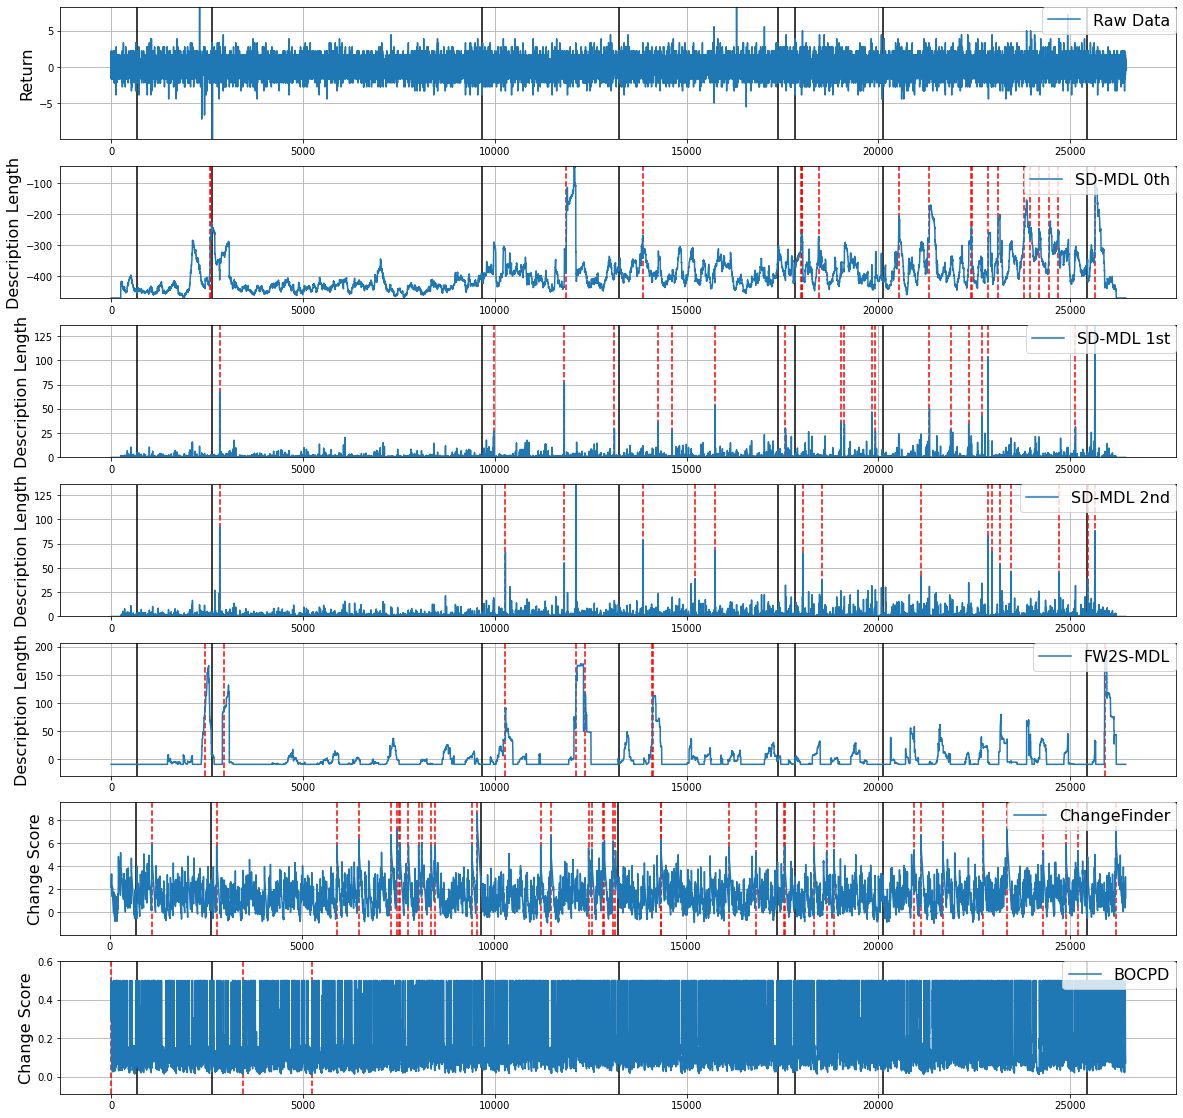

In [28]:
def alarm_making(scores, threshold):
    alarms = np.where(scores >= threshold, 1, 0)
    alarms[0] = 0
    alarms[-1] = 0
    diff = np.diff(alarms)

    start = np.where(diff == 1)[0]
    
    return start

# fill na
sdmdl_0_scores[np.isnan(sdmdl_0_scores)] = np.nanmin(sdmdl_0_scores)
sdmdl_1_scores[np.isnan(sdmdl_1_scores)] = np.nanmin(sdmdl_1_scores)
sdmdl_2_scores[np.isnan(sdmdl_2_scores)] = np.nanmin(sdmdl_2_scores)
fw2s_mdl_scores[np.isnan(fw2s_mdl_scores)] = np.nanmin(fw2s_mdl_scores)

sdmdl_1_scores = np.where(sdmdl_1_scores < 0, 0, sdmdl_1_scores)
sdmdl_2_scores = np.where(sdmdl_2_scores < 0, 0, sdmdl_2_scores)

# AUC
print("SDMDL 0th: ", calc_AUC(sdmdl_0_scores,
                              changepoints,  tolerance_delay, both=both))
print("SDMDL 1st: ", calc_AUC(sdmdl_1_scores,
                              changepoints,  tolerance_delay, both=both))
print("SDMDL 2nd: ", calc_AUC(sdmdl_2_scores,
                              changepoints,  tolerance_delay, both=both))
print("FW2S-MDL: ", calc_AUC(fw2s_mdl_scores,
                             changepoints,  tolerance_delay, both=both))
print("ChangeFinder: ", calc_AUC(
    cf_scores, changepoints,  tolerance_delay, both=both))
print("BOCPD: ", calc_AUC(bocpd_scores, changepoints,  tolerance_delay, both=both))

# F1 and threshold tuning
sdmdl_0_F1, _, _, sdmdl_0_threshold = calc_F1_score(
    sdmdl_0_scores, changepoints, tolerance_delay)
sdmdl_1_F1, _, _, sdmdl_1_threshold = calc_F1_score(
    sdmdl_1_scores, changepoints, tolerance_delay)
sdmdl_2_F1, _, _, sdmdl_2_threshold = calc_F1_score(
    sdmdl_2_scores, changepoints, tolerance_delay)
fw2s_mdl_F1, _, _, fw2s_mdl_threshold = calc_F1_score(
    fw2s_mdl_scores, changepoints, tolerance_delay)
cf_F1, _, _, cf_threshold = calc_F1_score(
    cf_scores, changepoints, tolerance_delay)
bocpd_F1, _, _, bocpd_threshold = calc_F1_score(
    bocpd_scores, changepoints, tolerance_delay)

sdmdl_0_alarm=alarm_making(sdmdl_0_scores, sdmdl_0_threshold)
sdmdl_1_alarm=alarm_making(sdmdl_1_scores, sdmdl_1_threshold)
sdmdl_2_alarm=alarm_making(sdmdl_2_scores, sdmdl_2_threshold)
fw2s_mdl_alarm=alarm_making(fw2s_mdl_scores, fw2s_mdl_threshold)
cf_alarm=alarm_making(cf_scores, cf_threshold)
bocpd_alarm=alarm_making(bocpd_scores, bocpd_threshold)

print("SDMDL 0th: ", (sdmdl_0_F1, sdmdl_0_threshold))
print("SDMDL 1st: ", (sdmdl_1_F1, sdmdl_1_threshold))
print("SDMDL 2nd: ", (sdmdl_2_F1, sdmdl_2_threshold))
print("FW2S-MDL: ", (fw2s_mdl_F1, fw2s_mdl_threshold))
print("ChangeFinder: ", (cf_F1, cf_threshold))
print("BOCPD: ", (bocpd_F1, bocpd_threshold))


plt.clf()
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 20))

fontsize = 16

axes[0].plot(X[0], label='Raw Data')
axes[0].set_ylabel('Return', fontsize=fontsize)
axes[0].vlines(changepoints, np.min(X[0]), np.max(X[0]), color="black")
axes[0].set_ylim(np.min(X[0]), np.max(X[0]))
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[0].grid(True)

axes[1].plot(sdmdl_0_scores, label='SD-MDL 0th')
axes[1].set_ylabel('Description Length', fontsize=fontsize)
axes[1].vlines(changepoints, np.nanmin(sdmdl_0_scores)-1, np.nanmax(sdmdl_0_scores)+1, color="black")
axes[1].vlines(sdmdl_0_alarm, np.nanmin(sdmdl_0_scores)-1, np.nanmax(sdmdl_0_scores)+1, color="red", linestyle="dashed")
axes[1].set_ylim(np.nanmin(sdmdl_0_scores)-1, np.nanmax(sdmdl_0_scores)+1)
axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[1].grid(True)

axes[2].plot(sdmdl_1_scores, label='SD-MDL 1st')
axes[2].set_ylabel('Description Length', fontsize=fontsize)
axes[2].vlines(changepoints, 0, np.nanmax(sdmdl_1_scores), color="black")
axes[2].vlines(sdmdl_1_alarm, 0, np.nanmax(sdmdl_1_scores)+1, color="red", linestyle="dashed")
axes[2].set_ylim(0, np.nanmax(sdmdl_1_scores))
axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[2].grid(True)

axes[3].plot(sdmdl_2_scores, label='SD-MDL 2nd')
axes[3].set_ylabel('Description Length', fontsize=fontsize)
axes[3].vlines(changepoints, 0, np.nanmax(sdmdl_2_scores), color="black")
axes[3].vlines(sdmdl_2_alarm, 0, np.nanmax(sdmdl_2_scores)+1, color="red", linestyle="dashed")
axes[3].set_ylim(0, np.nanmax(sdmdl_1_scores))
axes[3].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[3].grid(True)


axes[4].plot(fw2s_mdl_scores, label='FW2S-MDL')
axes[4].set_ylabel('Description Length', fontsize=fontsize)
axes[4].vlines(changepoints, np.nanmin(fw2s_mdl_scores)-20, np.nanmax(fw2s_mdl_scores)+20, color="black")
axes[4].vlines(fw2s_mdl_alarm,np.nanmin(fw2s_mdl_scores)-20, np.nanmax(fw2s_mdl_scores)+20, color="red", linestyle="dashed")
axes[4].set_ylim(np.nanmin(fw2s_mdl_scores)-20, np.nanmax(fw2s_mdl_scores)+20)
axes[4].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[4].grid(True)

axes[5].plot(cf_scores, label='ChangeFinder')
axes[5].set_ylabel('Change Score', fontsize=fontsize)
axes[5].vlines(changepoints, np.nanmin(cf_scores)-1, np.nanmax(cf_scores)+1, color="black")
axes[5].vlines(cf_alarm, np.nanmin(cf_scores)-1, np.nanmax(cf_scores)+1, color="red", linestyle="dashed")
axes[5].set_ylim(np.nanmin(cf_scores)-1, np.nanmax(cf_scores)+1)
axes[5].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[5].grid(True)

axes[6].plot(bocpd_scores, label='BOCPD')
axes[6].set_ylabel('Change Score', fontsize=fontsize)
axes[6].vlines(changepoints, np.nanmin(bocpd_scores)-0.1, np.nanmax(bocpd_scores)+0.1, color="black")
axes[6].vlines(bocpd_alarm, np.nanmin(bocpd_scores)-0.1, np.nanmax(bocpd_scores)+0.1, color="red", linestyle="dashed")
axes[6].set_ylim(np.nanmin(bocpd_scores)-0.1, np.nanmax(bocpd_scores)+0.1)
axes[6].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[6].grid(True)